## **Quick Overview**

1. Data Loading
2. Apply K-Means Clustering, so that similar company grouped in a same cluster.
3. Merge the dataset of the company which are in same cluster.
4. Separate the class label from the dataset ie. Revenue, income class label. And fill the 'inf' value with the '0' because droping them was not a good idea since we already have less data and so model will not be able to train so well.
5. Since we have more than 300 features so after applying PCA, we reduced the dimension and using covariance graph, I figure out only 5-12 feature are important for each clusters.
6. Created Two function to train a model for revenue and income prediction.

In [ ]:
!unzip /content/Recruitment+Problem+Files.zip

Archive:  /content/Recruitment+Problem+Files.zip
   creating: Recruitment Problem Files/
   creating: Recruitment Problem Files/historicalData/
   creating: Recruitment Problem Files/historicalData/qq16p1Data/
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/ABT.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/ADBE.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/AMGN.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/AMZN.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/BA.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/BIIB.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/BKNG.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/BMY.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/CAT.csv  
  inflating: Recruitment Problem Files/historicalData/qq16p1Data/CELG.csv  
  inflating: Recruitment Problem Fi

# **Loading the Required Libraray**

In [ ]:
import pandas_datareader.data as web
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA 

import pandas as pd
import numpy as np
import datetime
import os
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import pickle

## **Loading the Dataset**

In [ ]:
#Declare the dataframe.

dt = []
Clust0 = []
Clust1 = []
Clust2 = []
Clust3 = []
Clust4 = []
Clust5 = []
Clust6 = []
Clust7 = []
Clust8 = []
Clust9 = []
df_list = []
df_income = []

In [ ]:
#Loading the dataset from the directory

for companies in os.listdir("/content/Recruitment Problem Files/historicalData/qq16p1Data"):
  if not companies.strip('').split('.')[0] == '':
      dt.append(companies.strip('').split('.')[0])

# **Clustering the Stocks**

1. The data source we'll be using for the companies will be Yahoo Finance and we'll read in the data with pandas-datareader.

2. We're also going to define the start and end dates - we're going to use 10 years of data from 2010-01-01 to 2020-01-01. Then we're going to use web.DataReader() to load the companies we're interested in.

3. Now let's move on to calculating the daily stock movements, since it's off of this movement that we want to cluster our data. To do this we're first going to convert our stock_open and stock_close values to a numpy array. Also, since these values are currently a column vector for each day we're going to use .T to take the transpose of these and give us row vectors instead.

We're then going to create a movements dataset, and we'll start with a blank numpy array filled with 0's for now.

We're then going to write a for loop to assign the daily movement (stock_close - stock_open) for all the dates.

In [ ]:
# Define which online source to use
data_source = 'yahoo'

# define start and end dates
start_date = '2010-01-01'
end_date = '2020-01-01'

# Use pandas_datareader.data.DataReader to load the desired data list(companies_dict.values()) used for python 3 compatibility
panel_data = web.DataReader(list(dt), data_source, start_date, end_date)
# Find Stock Open and Close Values
stock_close = panel_data['Close']
stock_open = panel_data['Open']

In [ ]:
# Calculate daily stock movement
stock_close = np.array(stock_close).T
stock_open = np.array(stock_open).T

row, col = stock_close.shape

# create movements dataset filled with 0's
movements = np.zeros([row, col])

for i in range(0, row):
 movements[i,:] = np.subtract(stock_close[i,:], stock_open[i,:])

## **K-Mean Clustering**

In this article, we're going to going to train a k-means clustering algorithm to group companies based on their stock market movements over a 10-year period.

Even though we've just normalized the data, we're going to use normalize again in a 
pipeline just to see how pipelines work in scikit-learn. We're then going to apply a K-Means algo with 10 clusters. Finally we'll make a pipeline that chains together the normalizer and the k-means clustering algorithm.


We can see we still have some of the tech stocks clustered together, Pharma companies are clustered together, and transport companies also clustered together.

But there will be few company which will not be clustered so well but still that are very few.

In [ ]:
# define normalizer
normalizer = Normalizer()

# create a K-means model with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter=2000)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)
# fit pipeline to daily stock movements
pipeline.fit(movements)
# predict cluster labels
labels = pipeline.predict(movements)

# create a DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': dt})

# display df sorted by cluster labels
print(df.sort_values('labels'))
df_set=df.set_index("companies")

    labels companies
37       0       XOM
36       0       COP
15       0       CVX
10       0       SLB
8        0       OXY
19       1      BKNG
23       1      ADBE
24       1      AMZN
22       1      MSFT
30       1      NVDA
33       1      NFLX
4        1       TXN
34       1        MA
20       1      INTC
32       2       MMM
29       2       HON
28       2         F
27       2       FDX
31       2       TGT
0        2       CAT
39       2        GE
3        2       EMR
16       2       UPS
48       2       UNP
46       2       IBM
2        3       DHR
45       3       PFE
14       3       MRK
21       3       JNJ
26       3       ABT
44       4        CL
40       4        MO
47       4        KO
17       4      MDLZ
35       4        PM
42       5         T
9        5     CMCSA
1        5        VZ
18       6       MCD
41       7       RTN
25       7       LMT
5        7        GD
38       7        BA
13       8       WMT
12       8       SPG
7        8       UNH
6        8   

**This snippet of code is responsible for the merging the dataset of those company which are grouped in a same cluster.**

In [ ]:
'''  will be responsible for the merging the dataset of the company which are grouped in a same cluster
and for each cluster we are going to train the model on the combined dataset.'''

for comp in os.listdir("/content/Recruitment Problem Files/historicalData/qq16p1Data"):
  try:
    name  = comp.strip().split('.')[0]
    df_temp = pd.read_csv("/content/Recruitment Problem Files/historicalData/qq16p1Data/" +comp.strip(),engine='python')
    if df_set.loc[name]['labels'] == 0:
      #append
      Clust0.append(df_temp)
    elif df_set.loc[name]['labels'] == 1:
      #apped
      Clust1.append(df_temp)
    elif df_set.loc[name]['labels'] == 2:
      #apped
      Clust2.append(df_temp)
    elif df_set.loc[name]['labels'] == 3:
      #apped
      Clust3.append(df_temp)
    elif df_set.loc[name]['labels'] == 4:
      #apped
      Clust4.append(df_temp)
    elif df_set.loc[name]['labels'] == 5:
      #apped
      Clust5.append(df_temp)
    elif df_set.loc[name]['labels'] == 6:
      #apped
      Clust6.append(df_temp)
    elif df_set.loc[name]['labels'] == 7:
      #apped
      Clust7.append(df_temp)
    elif df_set.loc[name]['labels'] == 8:
      #apped
      Clust8.append(df_temp)
    elif df_set.loc[name]['labels'] == 9:
      #apped
      Clust9.append(df_temp)
 
  except:
    print(comp + 'ye wala error')

.ipynb_checkpointsye wala error


In [ ]:
#Separate the class label from the dataset ie. Revenue, income class label. 
#And fill the 'inf' value with the '0' because droping them was not a good idea since we 
#already have less data and so model will not be able to train so well.

clust0 = pd.concat(Clust0,ignore_index='TRUE')
clust1 = pd.concat(Clust1,ignore_index='TRUE')
clust2 = pd.concat(Clust2,ignore_index='TRUE')
clust3 = pd.concat(Clust3,ignore_index='TRUE')
clust4 = pd.concat(Clust4,ignore_index='TRUE')
clust5 = pd.concat(Clust5,ignore_index='TRUE')
clust6 = pd.concat(Clust6,ignore_index='TRUE')
clust7 = pd.concat(Clust7,ignore_index='TRUE')
clust8 = pd.concat(Clust8,ignore_index='TRUE')
clust9 = pd.concat(Clust9,ignore_index='TRUE')



clust0 = clust0.replace([np.inf, -np.inf], np.nan)
clust1 = clust1.replace([np.inf, -np.inf], np.nan)
clust2 = clust2.replace([np.inf, -np.inf], np.nan)
clust3 = clust3.replace([np.inf, -np.inf], np.nan)
clust4 = clust4.replace([np.inf, -np.inf], np.nan)
clust5 = clust5.replace([np.inf, -np.inf], np.nan)
clust6 = clust6.replace([np.inf, -np.inf], np.nan)
clust7 = clust7.replace([np.inf, -np.inf], np.nan)
clust8 = clust8.replace([np.inf, -np.inf], np.nan)
clust9 = clust9.replace([np.inf, -np.inf], np.nan)


clust0 =clust0.fillna(0)
clust1 =clust1.fillna(0)
clust2 =clust2.fillna(0)
clust3 =clust3.fillna(0)
clust4 =clust4.fillna(0)
clust5 =clust5.fillna(0)
clust6 =clust6.fillna(0)
clust7 =clust7.fillna(0)
clust8 =clust8.fillna(0)
clust9 =clust9.fillna(0)


clust0 = clust0.drop(["time"],axis=1)
clust1 = clust1.drop(["time"],axis=1)
clust2 = clust2.drop(["time"],axis=1)
clust3 = clust3.drop(["time"],axis=1)
clust4 = clust4.drop(["time"],axis=1)
clust5 = clust5.drop(["time"],axis=1)
clust6 = clust6.drop(["time"],axis=1)
clust7 = clust7.drop(["time"],axis=1)
clust8 = clust8.drop(["time"],axis=1)
clust9 = clust9.drop(["time"],axis=1)

clust_0_income = clust0['Income(Y)']
clust_1_income = clust1['Income(Y)']
clust_2_income = clust2['Income(Y)']
clust_3_income = clust3['Income(Y)']
clust_4_income = clust4['Income(Y)']
clust_5_income = clust5['Income(Y)']
clust_6_income = clust6['Income(Y)']
clust_7_income = clust7['Income(Y)']
clust_8_income = clust8['Income(Y)']
clust_9_income = clust9['Income(Y)']


clust_0_revenue  = clust0['Revenue(Y)']
clust_1_revenue  = clust1['Revenue(Y)']
clust_2_revenue  = clust2['Revenue(Y)']
clust_3_revenue  = clust3['Revenue(Y)']
clust_4_revenue  = clust4['Revenue(Y)']
clust_5_revenue  = clust5['Revenue(Y)']
clust_6_revenue  = clust6['Revenue(Y)']
clust_7_revenue  = clust7['Revenue(Y)']
clust_8_revenue  = clust8['Revenue(Y)']
clust_9_revenue  = clust9['Revenue(Y)']



    

clust0 = clust0.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust1 = clust1.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust2 = clust2.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust3 = clust3.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust4 = clust4.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust5 = clust5.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust6 = clust6.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust7 = clust7.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust8 = clust8.drop(['Income(Y)','Revenue(Y)'],axis=1)
clust9 = clust9.drop(['Income(Y)','Revenue(Y)'],axis=1)

# **PCA:** 
We are now going to do a linear dimensionality reduction using singular value decomposition of the data.

We're going to do this to project it to a lower dimensional space so that we can graphically represent the different clusters.

We're first going to use PCA from sklearn.decomposition on every cluster taht we have

But How we decide, to which extent we should reduce our dimension of our data? For this we have used **"expalined_variance"**, **"percentage_var_exp"** ,  "**cum_var_explained**" parameter from PCA which tells us ho many features are 

**For every cluster the 100% of the variance is going to explained with only 5 features and thats Why i have reduced my 300 features to 5 features without loosing any information. As you can see in the above graph.**

[PCA YouTube Link for the refernce](https://youtu.be/l28O3M0gv6w)

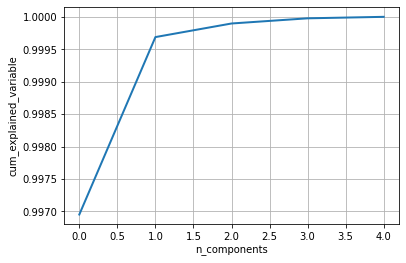

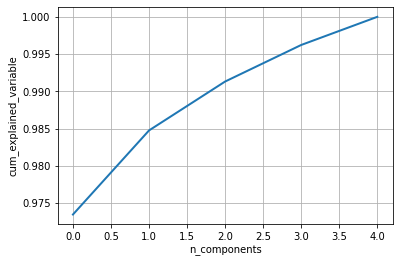

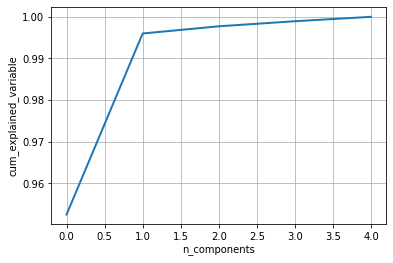

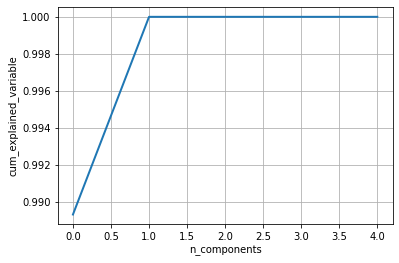

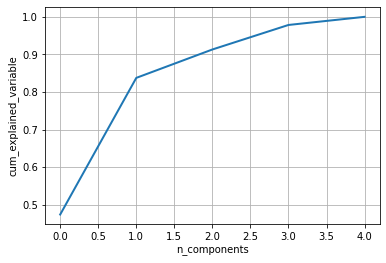

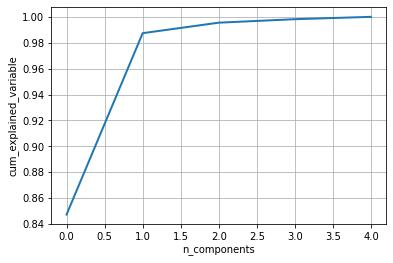

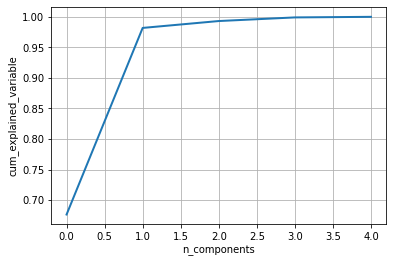

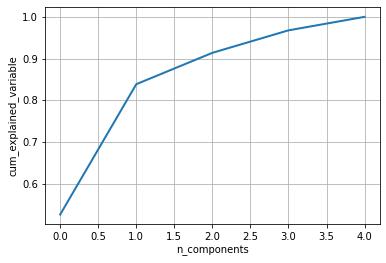

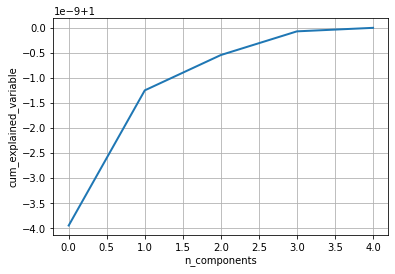

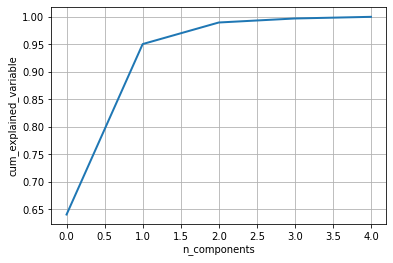

In [ ]:
df_list = []
clust_list = [clust0,clust1,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9]

for i in clust_list:
  pca = PCA(n_components=5)
  tmp = pca.fit_transform(i)
  df_list.append(tmp)
  percentage_var_exp = pca.explained_variance_/np.sum(pca.explained_variance_)
  cum_var_explained = np.cumsum(percentage_var_exp)


  plt.figure(1,figsize = (6,4))
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('cum_explained_variable')
  plt.show()

In [ ]:
df_list[0]

array([[-9.20673202e+04, -9.59160804e+03, -6.13565797e+01,
        -2.56940725e+01, -2.67798812e+00],
       [-9.20672602e+04, -9.59174037e+03, -6.12164284e+01,
        -2.64971745e+01, -2.71752404e+00],
       [-9.20670322e+04, -9.59180015e+03, -6.03563650e+01,
        -2.62516045e+01, -2.76411308e+00],
       ...,
       [-9.19934456e+04, -9.58115847e+03,  2.44771466e+02,
         3.67284476e+01,  1.48024917e+00],
       [-9.19931060e+04, -9.56986475e+03,  1.99644651e+02,
         3.47766116e+01,  3.80488524e+00],
       [-9.19852590e+04, -9.57877014e+03,  2.18277380e+02,
         2.30525475e+01, -8.16178922e-01]])

# **Model Building:**

0. we have 10 clusters and so we have to build 10 model.

1. Income_Y contains the list of class label of repective cluster eg: clust_0_income contains the class label(income) of cluster 0. And similary Revenue_Y also.

2. create_model() function actually a xgboostregressor model in which i have used Hyperparameter optimization using randomizedsearchCV.
I have also used Linear regression but for many clusters it was giving worst result.
3. We are performing hyperperameter tuning for each cluster separately because each clusters have different kind of companies list and so each can have different factors which affect the companies future Income and revenue evaluation.

**Note: I have made function sucha a way that we should know, to which cluster our test data should belongs to and Below for this instance I have made the categories of clusters eg:clusters_0 -> Pharmaceutical .**

In [ ]:
Income_Y = [clust_0_income,clust_1_income,clust_2_income,clust_3_income,clust_4_income,
            clust_5_income,clust_6_income,clust_7_income,clust_9_income]
Revenue_Y = [clust_0_revenue,clust_1_revenue,clust_2_revenue,clust_3_revenue,clust_4_revenue,
              clust_5_revenue,clust_6_revenue,clust_7_revenue,clust_8_revenue,clust_9_revenue]

In [ ]:
def create_model(X,Y):
  ## Hyper Parameter Optimization
  regressor=xgboost.XGBRegressor()
  n_estimators = [100, 500, 900, 1100, 1500]
  max_depth = [2, 3, 5, 10, 15]
  booster=['gbtree','gblinear']
  learning_rate=[0.05,0.1,0.15,0.20]
  min_child_weight=[1,2,3,4]
  base_score=[0.25,0.5,0.75,1]
  # Define the grid of hyperparameters to search
  hyperparameter_grid = {
      'n_estimators': n_estimators,
      'max_depth':max_depth,
      'learning_rate':learning_rate,
      'min_child_weight':min_child_weight,
      'booster':booster,
      'base_score':base_score
     }



# Set up the random search with 4-fold cross validation
  random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

  random_cv.fit(X,Y)
  regressor=xgboost.XGBRegressor(regressor = random_cv.best_estimator_)
  regressor.fit(X,Y)
  return regressor
  

  

  # filename = 'finalized_model.pkl'
  # pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
def get_pred(model,X):
  y = model.predict(X)
  return y

In [ ]:
#function to get income prediction
#parameters:
# X-> company data (X can only have numerical values and cannot have nan/inf values)
# cluster_type -> can be one of the following integer values corresponding to inustry types:
# 0 -> Pharmaceutical
# 1 -> Health/Insurance
# 2 -> Information Technology
# 3 -> Energy
# 4 -> Retail chain
# 5 -> Electronics
# 6 -> Logistics
# 7 -> Defense
# 8 -> Real Estate
# 9 -> Food and Beverages
def get_income(X,cluster_type):
  pca = PCA(n_components=5)
  X_ = pca.fit_transform(X)
  model=create_model(df_list[cluster_type],Income_Y[cluster_type])
  return get_pred(model,X_)

In [ ]:
#function to get revenue prediction
#parameters:
# X-> company data (X can only have numerical values and cannot have nan/inf values)
# cluster_type -> can be one of the following integer values corresponding to inustry types:
# 0 -> Pharmaceutical
# 1 -> Health/Insurance
# 2 -> Information Technology
# 3 -> Energy
# 4 -> Retail chain
# 5 -> Electronics
# 6 -> Logistics
# 7 -> Defense
# 8 -> Real Estate
# 9 -> Food and Beverages
def get_revenue(X,cluster_type):
  pca = PCA(n_components=5)
  X_ = pca.fit_transform(X)
  model=create_model(df_list[cluster_type],Revenue_Y[cluster_type])
  return get_pred(model,X_)

In [ ]:
#TESTING FUNCTION FOR REVENUE PREDICTION

#########################################################################################
# get_revenue function takes two arguments:                                             #
# 1. df_list represent the list of clusters that we have build earlier                  #                    # 
#    which means df_list[0] have processed data of cluster_0.                           #
# 2. second arguments represents the cluster label or which cluster it belongs to       #                      #
#########################################################################################

# Note: for testing we should know first, to which cluster our test data belongs to.
out=get_revenue(df_list[0],0)
def mean_squared_error_custom(truth, predicted):
  m = truth.shape[0]
  mse = (np.sum((predicted - truth)**2)) / (2*m)
  return mse
print("Mean squared error for revenue")
print(mean_squared_error_custom(Revenue_Y[0], out))
print(out)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   21.5s


[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error for revenue
0.006595002546105576
[ 5.7050037e-01  4.2336792e-01  4.7036779e-01  4.9043384e-01
  4.7999990e-01  4.1603997e-01  4.9278212e-01  4.4967088e-01
  6.3256294e-01  4.8301062e-01  4.6079817e-01  5.0382763e-01
  4.8704961e-01  6.1165875e-01  6.0765094e-01  5.1232147e-01
  6.2377340e-01  3.9236289e-01  3.9236289e-01  5.6044233e-01
  5.3331256e-01  4.3913621e-01  4.1461957e-01  4.3628472e-01
  3.8195267e-01  4.0602520e-01  3.6629933e-01  4.7101146e-01
  3.2599527e-01  3.2204437e-01  3.1502581e-01  3.8568014e-01
  3.7857634e-01  3.1458789e-01  4.9632931e-01  3.6124647e-01
  4.5738941e-01  5.0318795e-01  4.7441053e-01  4.1299969e-01
  4.9524459e-01  5.0213617e-01  5.0893432e-01  5.3067166e-01
  6.5084761e-01  6.8004

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   39.1s finished


**Conclusion : We have tested our model as cluster_0 as our test data and we are trying to predict the Income and so we have mse = 0.006595002546105576**

In [ ]:
#TESTING FUNCTION FOR INCOME PREDICTION

#########################################################################################
# get_revenue function takes two arguments:                                             #
# 1. df_list represent the list of clusters that we have build earlier                  #                    # 
#    which means df_list[0] have processed data of cluster_0.                           #
# 2. second arguments represents the cluster label or which cluster it belongs to       #                      #
#########################################################################################

# Note: for testing we should know first, to which cluster our test data belongs to.
out=get_income(df_list[0],0)
def mean_squared_error_custom(truth, predicted):
  m = truth.shape[0]
  mse = (np.sum((predicted - truth)**2)) / (2*m)
  return mse
print("Mean squared error for revenue")
print(mean_squared_error_custom(Revenue_Y[0], out))
print(out)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   22.7s


[17:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error for revenue
0.5207882791074183
[0.20421708 0.17082292 0.19876227 0.19741422 0.21353021 0.23358545
 0.26563662 0.26652855 0.2783613  0.2876833  0.2723975  0.26101533
 0.26360488 0.26015288 0.26567063 0.26854822 0.2561962  0.2276276
 0.23536178 0.22075027 0.23589659 0.22458106 0.20853272 0.20138496
 0.12649381 0.11535034 0.1094012  0.14342952 0.10765368 0.09431332
 0.13413799 0.16420037 0.1180214  0.1288495  0.19104004 0.17848983
 0.13730589 0.13465777 0.13465777 0.12033102 0.12842017 0.14903742
 0.16012737 0.17296949 0.17681983 0.19008431 0.19285232 0.16256368
 0.20946169 0.21225253 0.20632014 0.20436919 0.21428004 0.2114892
 0.22923315 0.23157918 0.2355735  0.21667728 0.21667728 0.21667728
 0.16149935 0.15882131 0.157

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   40.6s finished


**Conclusion : We have tested our model as cluster_0 as our test data and we are trying to predict the Income and so we have mse = 0.5207882791074183**

REFERENCE'S

1. Applied AI Youtube video for PCA 
2. Krish Naik yotube video
3. Few Technical blog's for stock market understanding.
4. Random articles.
